<a href="https://colab.research.google.com/github/WeiChenTseng/Titanic-analysis/blob/main/R_Breaker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# R-Breaker
邏輯：
* 空倉時：突破策略
    * 多趨勢：盤中價 > 突破買入價 -> 開倉做多
    * 空趨勢：盤中價 < 突破賣出價 -> 開倉做空
* 持倉時：反轉策略
    * 持多：(時段最高價>觀察賣出價 & 盤中價<反轉賣出價) or 空趨勢 -> 反做空or平倉
    * 持空：(時段最低價<觀察買入價 & 盤中價>反轉買入價) or 多趨勢 -> 反做多or平倉

In [ ]:
import os                       # 是导入标准库os， 利用其中的API 。
import numpy as np
import pandas as pd
import seaborn as sns           # 績效分析用
import matplotlib.pyplot as plt
import requests
import datetime as dt
import time

# 設定環境時區
import pytz
zone = pytz.timezone('UTC')     # 將時區設為UTC+0

## 資料生成

#### 讀檔

In [ ]:
# (2-1)from google drive
from google.colab import drive
drive.mount('/content/drive')
# 讀資料
data = pd.read_csv('drive/MyDrive/Colab Notebooks/Colab/TMBA/0821 分享/BTC_PERP.csv', parse_dates=True, index_col='startTime')
funding = pd.read_csv('drive/MyDrive/Colab Notebooks/Colab/TMBA/0821 分享/BTC_funding.csv', parse_dates=True, index_col='time')

Mounted at /content/drive


In [ ]:
# (2-2)from 本機檔案
path = os.getcwd()
data = pd.read_csv(path+'/BTC_PERP.csv', parse_dates=True, index_col='startTime')
funding = pd.read_csv(path+'/BTC_funding.csv', parse_dates=True, index_col='time')

#### 直接抓(備用)

In [ ]:
def Get_Price_Data(symbol, start, end, resolution):
    start_TimeStamp = int(dt.datetime.strptime(start, "%Y-%m-%d %H:%M:%S").replace(tzinfo=zone).timestamp())
    end_TimeStamp = int(dt.datetime.strptime(end, "%Y-%m-%d %H:%M:%S").replace(tzinfo=zone).timestamp())

    limit_PERP = 1500*resolution    # 最多1551筆  ( t ~ t+1500*resolution )
    limit_FUND = 499*3600        # 最多500筆   ( t ~ t+499*60*60 )

    ### ==================== 吃價格 =================== ###
    data_PERP=[]
    t1_last = start_TimeStamp
    t2_last = start_TimeStamp

    for t1,t2 in zip(range(start_TimeStamp, end_TimeStamp, limit_PERP), range(start_TimeStamp+limit_PERP, end_TimeStamp, limit_PERP)):
        url1 = 'https://ftx.com/api/markets/{}/candles?resolution={}&start_time={}&end_time={}'.format(symbol, resolution, t1, t2)
        req1 = requests.get(url1).json()['result'][:-1]                # 避免下一筆吃尾
        data_PERP += req1
        t1_last = t1
        t2_last = t2

    # 抓最後一次 (迴圈沒抓到的)
    if (end_TimeStamp-start_TimeStamp)<=limit_PERP:  t1_remain = 0     # 避免初次抓就在上限內 讀取不到的問題
    else: t1_remain = limit_PERP

    t1_last += t1_remain
    t2_last += int(end_TimeStamp - start_TimeStamp)%limit_PERP
    url1 = 'https://ftx.com/api/markets/{}/candles?resolution={}&start_time={}&end_time={}'.format(symbol, resolution, t1_last, t2_last)
    req1 = requests.get(url1).json()['result'] 
    data_PERP += req1


    ## ==================== 吃資金費 =================== ###
    data_FUND=[]
    t1_last = start_TimeStamp
    t2_last = start_TimeStamp

    for t1,t2 in zip(range(start_TimeStamp, end_TimeStamp, limit_FUND), range(start_TimeStamp+limit_FUND, end_TimeStamp, limit_FUND)):
        url2 = 'https://ftx.com/api/funding_rates?start_time={}&end_time={}&future={}'.format(t1, t2, symbol)
        req2 = requests.get(url2).json()['result'][1:][::-1]           # 避免下一筆吃尾(注意倒過來過來問題)
        data_FUND += req2
        t1_last = t1
        t2_last = t2

    if (end_TimeStamp-start_TimeStamp)<=limit_FUND:  t1_remain = 0     # 避免第一次資料就在限制內讀取不到的問題
    else: t1_remain = limit_FUND

    t1_last += t1_remain
    t2_last += int(end_TimeStamp - start_TimeStamp)%limit_FUND
    url2 = 'https://ftx.com/api/funding_rates?start_time={}&end_time={}&future={}'.format(t1_last, t2_last, symbol)
    req2 = requests.get(url2).json()['result'][:][::-1] 
    data_FUND += req2


    # 改格式 時間標為index
    data_PERP = pd.DataFrame(data_PERP)
    data_FUND = pd.DataFrame(data_FUND)
    data_PERP.index = pd.to_datetime(data_PERP['startTime'])
    data_FUND.index = pd.to_datetime(data_FUND['time'])
    data_PERP = data_PERP[['open', 'high', 'low', 'close', 'volume']]
    data_FUND = data_FUND[['rate']]

    return (data_PERP, data_FUND)

In [ ]:
symbol = 'BTC-PERP'

start = '2021-1-1 00:00:00'
end = '2022-7-31 23:59:00'
resolution = 60        #60秒->分K資料

# Get_Price_Data(symbol, start, end, resolution)
PriceData = Get_Price_Data(symbol, start, end, resolution)

# return (data_PERP, data_FUND)
data = PriceData[0]
funding = PriceData[1]

NameError: ignored

## Function設定

#### 基本資料

In [ ]:
InSample = '2022-2'
OutSample = '2022-3'

fund = 10000         # 初始有10000元本金
money = 10000        # 每次投入10000元
feeRate = 0.0015


df_hour = data.resample(rule='1H', closed='left', label='left').first()[['open']]  # 開盤價算資金費
df_funding = pd.concat([df_hour, funding], axis=1)

# +-+-+-+-+-+-+ 資金費 +-+-+-+-+-+-+
def fundingPayment(df_funding, side, unit, t1, t2):
    
    if len(df_funding.loc[t1:t2]) == 0: # ex: 8:05-8:06 因為沒有在一小時所以funding fee = 0
        fee = 0
    else:
        fr = np.array(df_funding.loc[t1:t2])
        fee = unit * np.dot(fr[:,0],fr[:,1]) # open*rate再乘unit        
    if side == 'long':
        return -fee       # long支付fee
    elif side == 'short':
        return fee        # short得到fee



# +-+-+-+-+-+-+ 樣本切割 +-+-+-+-+-+-+
def Sample_Producing(data, SampleType):
    if SampleType == 'In': Sample = data[:InSample].copy()
    elif SampleType == 'Out': Sample = data[OutSample:].copy()
    elif SampleType == "All": Sample = data.copy()
    return Sample  

#### 回測過程

In [ ]:
# +-+-+-+-+-+-+ 關鍵價格 +-+-+-+-+-+-+ 
def KeyPrice_Producing(Sample, PriceType, signal_interval, bre, set, ent):
     if PriceType == 'Fixed':   #固定版本
          high  = np.array(Sample.resample(rule=f"{signal_interval}T", closed='left', label='right').max()[['high']][:-1])
          low   = np.array(Sample.resample(rule=f"{signal_interval}T", closed='left', label='right').min()[['low']][:-1])
          close = np.array(Sample.resample(rule=f"{signal_interval}T", closed='left', label='right').last()[['close']][:-1])
          pivot = (high + low + close)/3
          bbreak = high + bre*(pivot-low  )
          sbreak =  low - bre*( high-pivot)
          ssetup = high + set*(pivot-low  )
          bsetup =  low - set*( high-pivot)
          senter =  low + ent*(pivot-low  )
          benter = high - ent*( high-pivot)         
     return (high, low, bbreak, sbreak, ssetup, bsetup, senter, benter)

#high, low, bbreak, sbreak, ssetup, bsetup, senter, benter

# +-+-+-+-+-+-+ 回測過程 +-+-+-+-+-+-+ 
def BackTest_Processing(Sample, PriceType, reverseType, signal_interval, bre, set, ent, LoseStop):
        
    # 關鍵價格
    KeyPrice = KeyPrice_Producing(Sample, PriceType, signal_interval, bre, set, ent)
    high   = KeyPrice[0]
    low    = KeyPrice[1]
    bbreak = KeyPrice[2]
    sbreak = KeyPrice[3]
    ssetup = KeyPrice[4]
    bsetup = KeyPrice[5]
    senter = KeyPrice[6]
    benter = KeyPrice[7]

    # 數據儲存區
    BS = None
    buy = []
    sell = []
    sellshort = []
    buytocover = []
    profit_list = [0]
    profit_fee_list = [0]
    profit_fee_list_realized = []
    tempFund = fund    #計算現有金

    # 帶入判斷的進出場價格
    open_In = np.array(Sample[['open']][signal_interval:])      # 生成壓力線時間不判斷，下根開始判斷 -> [signal_interval:]
    close_In = np.array(Sample[['close']][signal_interval:])
    times = len(close_In)
    timeIndex = np.array(Sample.index[signal_interval:])

    tempMax = close_In[0]
    tempMin = close_In[0]
    # 固定版本 -> 有j
    if (PriceType == 'Fixed'):
        # 反操
        if (reverseType == 'Operate'):
            for i in range(0, times-1):         # 最後1根K不判斷，僅期末平倉 -> times-1
                j = i//signal_interval+1

                if tempFund == 0: break         # 沒錢就ㄅㄅ (斷頭直接出迴圈算績效)

            # 開新倉
                elif BS == None: 
                    profit_list.append(0)
                    profit_fee_list.append(0)  
                    tempFund += profit_fee_list[i]              # 考慮虧損拿不出原資金下單
                    tempMoney = max(0, min(tempFund, money))
                    if close_In[i] > bbreak[j-1]:
                        tempSize = tempMoney / open_In[i+1]     # 以本根K收判斷、下根開操作
                        feeIn = tempMoney*feeRate
                        BS = 'B'
                        buy.append(i+1)
                        tempMax = open_In[i+1]   # 計算回降用
                        t = i+1                                          
                    elif close_In[i] < sbreak[j-1]:
                        tempSize = tempMoney / open_In[i+1]
                        feeIn = tempMoney*feeRate
                        BS = 'S'
                        sellshort.append(i+1)
                        tempMin = open_In[i+1]   # 計算回升用
                        t = i+1                    

            # 持倉 (含趨勢改變)
                elif BS == 'B':
                    tempMax = max(close_In[i], tempMax)

                    if (i == times-2):  #期末平倉 (前一期不判斷)
                        profit = tempSize * (close_In[i+1] - open_In[i])    # 期末用「下根收」平倉
                        profit_list.append(profit)

                        fundingFee = fundingPayment(df_funding, 'long', tempSize, timeIndex[t], timeIndex[i+1])   # 上次買入(t)到這次平倉(i+1)
                        feeOut = (tempSize*close_In[i+1])*feeRate
                        fee = feeIn + feeOut - fundingFee                   # fundingFee +- 已處理

                        profit_fee = profit - fee
                        profit_fee_list.append(profit_fee)
                        sell.append(i+1)
                        BS=None
                        # Realized PnL
                        profit_Realized = tempSize * (close_In[i+1] - open_In[t])   # 上次買入(t)到這次平倉(i+1)
                        profit_fee_realized = profit_Realized - fee
                        profit_fee_list_realized.append(profit_fee_realized)
                        break
                    
                    else:
                        # 平倉
                        profit = tempSize * (open_In[i+1] - open_In[i])       # 用「下根開」平倉
                        profit_list.append(profit)
                        fundingFee = fundingPayment(df_funding, 'long', tempSize, timeIndex[t], timeIndex[i+1])

                        # 回檔平倉
                        if (close_In[i] < tempMax*(1-LoseStop)):
                            feeOut = (tempSize*open_In[i+1])*feeRate
                            fee = feeIn + feeOut - fundingFee

                            profit_fee = profit - fee
                            profit_fee_list.append(profit_fee)
                            tempFund += profit_fee_list[i]   # 考慮虧損拿不出原資金下單
                            sell.append(i+1)
                            BS = None

                            # Realized PnL
                            profit_Realized = tempSize * (open_In[i+1] - open_In[t])   
                            profit_fee_realized = profit_Realized - fee
                            profit_fee_list_realized.append(profit_fee_realized)

                        elif (high[j-1]>ssetup[j-1] and close_In[i]<senter[j-1]) or (close_In[i]<sbreak[j-1]):
                            feeOut = (tempSize*open_In[i+1])*feeRate
                            fee = feeIn + feeOut - fundingFee

                            profit_fee = profit - fee
                            profit_fee_list.append(profit_fee)
                            tempFund += profit_fee_list[i]   # 考慮虧損拿不出原資金下單
                            sell.append(i+1)

                            # Realized PnL
                            profit_Realized = tempSize * (open_In[i+1] - open_In[t])   
                            profit_fee_realized = profit_Realized - fee
                            profit_fee_list_realized.append(profit_fee_realized)

                            # 再反向做                                
                            tempMoney = max(0, min(tempFund, money))
                            tempSize = tempMoney / open_In[i+1]
                            feeIn = tempMoney*feeRate                        
                            BS = 'S'
                            sellshort.append(i+1)
                            tempMin = open_In[i+1]   # 計算價格回檔
                            t = i+1

                        else: 
                            profit_fee = profit
                            profit_fee_list.append(profit_fee)
                            tempFund += profit_fee_list[i]

                elif BS == 'S' :
                    tempMin = min(close_In[i], tempMin)

                    if (i == times-2):  #期末平倉 (前一期不判斷)
                        profit = tempSize * (open_In[i]-close_In[i+1])    # 期末用「下根收」平倉
                        profit_list.append(profit)

                        fundingFee = fundingPayment(df_funding, 'short', tempSize, timeIndex[t], timeIndex[i+1])   # 上次賣出(t)到這次平倉(i+1)
                        feeOut = (tempSize*close_In[i+1])*feeRate
                        fee = feeIn + feeOut - fundingFee                 # fundingFee +- 已處理

                        profit_fee = profit - fee
                        profit_fee_list.append(profit_fee)
                        buytocover.append(i+1)
                        BS=None
                        # Realized PnL
                        profit_Realized = tempSize * (open_In[t] - close_In[i+1])   
                        profit_fee_realized = profit_Realized - fee
                        profit_fee_list_realized.append(profit_fee_realized)
                        break

                    else:
                        # 平倉
                        profit = tempSize * (open_In[i] - open_In[i+1])      
                        profit_list.append(profit)
                        fundingFee = fundingPayment(df_funding, 'short', tempSize, timeIndex[t], timeIndex[i+1])

                        # 回檔平倉
                        if (tempMin < close_In[i]*(1-LoseStop)):
                            feeOut = (tempSize*open_In[i+1])*feeRate
                            fee = feeIn + feeOut - fundingFee

                            profit_fee = profit - fee
                            profit_fee_list.append(profit_fee)
                            tempFund += profit_fee_list[i]   # 考慮虧損拿不出原資金下單
                            buytocover.append(i+1)    
                            BS=None

                            # Realized PnL
                            profit_Realized = tempSize * (open_In[t] - open_In[i+1])   # 上次賣出(t)到這次平倉(i+1)
                            profit_fee_realized = profit_Realized - fee
                            profit_fee_list_realized.append(profit_fee_realized)        # 算勝率用                        

                        elif (low[j-1]<bsetup[j-1] and close_In[i]>benter[j-1]) or (close_In[i]>bbreak[j-1]):
                            feeOut = (tempSize*open_In[i+1])*feeRate
                            fee = feeIn + feeOut - fundingFee

                            profit_fee = profit - fee
                            profit_fee_list.append(profit_fee)
                            tempFund += profit_fee_list[i]   # 考慮虧損拿不出原資金下單
                            buytocover.append(i+1)  

                            # Realized PnL
                            profit_Realized = tempSize * (open_In[t] - open_In[i+1])   # 上次賣出(t)到這次平倉(i+1)
                            profit_fee_realized = profit_Realized - fee
                            profit_fee_list_realized.append(profit_fee_realized)        # 算勝率用

                            # 再反向做
                            tempMoney = max(0, min(tempFund, money)) 
                            tempSize = tempMoney / open_In[i+1]            
                            feeIn = tempMoney*feeRate
                            BS = 'B'
                            buy.append(i+1)
                            tempMax = open_In[i+1]   # 計算價格回檔
                            t = i+1    

                        else: 
                            profit_fee = profit
                            profit_fee_list.append(profit_fee)
                            tempFund += profit_fee_list[i]    

        # 反平
        elif (reverseType == 'Offset'):
            for i in range(0, times-1):         # 最後1根K不判斷，僅期末平倉 -> times-1
                j = i//signal_interval+1

                if tempFund == 0: break         # 沒錢就ㄅㄅ (斷頭直接出迴圈算績效)

            # 開新倉
                elif BS == None: 
                    profit_list.append(0)
                    profit_fee_list.append(0)  
                    tempFund += profit_fee_list[i]              # 考慮虧損拿不出原資金下單
                    tempMoney = max(0, min(tempFund, money))
                    if close_In[i] > bbreak[j-1]:
                        tempSize = tempMoney / open_In[i+1]     # 以本根K收判斷、下根開操作
                        feeIn = tempMoney*feeRate
                        BS = 'B'
                        buy.append(i+1)
                        tempMax = open_In[i+1]   # 計算回降用
                        t = i+1                                          
                    elif close_In[i] < sbreak[j-1]:
                        tempSize = tempMoney / open_In[i+1]
                        feeIn = tempMoney*feeRate
                        BS = 'S'
                        sellshort.append(i+1)
                        tempMin = open_In[i+1]   # 計算回升用
                        t = i+1                    

            # 持倉 (含趨勢改變)
                elif BS == 'B':
                    tempMax = max(close_In[i], tempMax) # 當前收盤價與多單進場價格取大

                    if (i == times-2):  # 期末平倉 (前一期不判斷)
                        profit = tempSize * (close_In[i+1] - open_In[i])    # 期末用「下根收」平倉
                        profit_list.append(profit)

                        fundingFee = fundingPayment(df_funding, 'long', tempSize, timeIndex[t], timeIndex[i+1])   # 上次買入(t)到這次平倉(i+1)
                        feeOut = (tempSize*close_In[i+1])*feeRate
                        fee = feeIn + feeOut - fundingFee                   # fundingFee +- 已處理

                        profit_fee = profit - fee
                        profit_fee_list.append(profit_fee)
                        sell.append(i+1)
                        BS=None
                        # Realized PnL
                        profit_Realized = tempSize * (close_In[i+1] - open_In[t])   # 上次買入(t)到這次平倉(i+1)
                        profit_fee_realized = profit_Realized - fee
                        profit_fee_list_realized.append(profit_fee_realized)
                        break
                    
                    else:               # 訊號平倉                        
                        profit = tempSize * (open_In[i+1] - open_In[i])       # 用「下根開」平倉
                        profit_list.append(profit)
                        fundingFee = fundingPayment(df_funding, 'long', tempSize, timeIndex[t], timeIndex[i+1])

                        # 反向or回檔 平倉
                        if (high[j-1]>ssetup[j-1] and close_In[i]<senter[j-1]) or (close_In[i]<sbreak[j-1]) or (close_In[i] < tempMax*(1-LoseStop)):
                            feeOut = (tempSize*open_In[i+1])*feeRate
                            fee = feeIn + feeOut - fundingFee

                            profit_fee = profit - fee
                            profit_fee_list.append(profit_fee)
                            tempFund += profit_fee_list[i]   # 考慮虧損拿不出原資金下單
                            sell.append(i+1)
                            BS = None

                            # Realized PnL
                            profit_Realized = tempSize * (open_In[i+1] - open_In[t])   
                            profit_fee_realized = profit_Realized - fee
                            profit_fee_list_realized.append(profit_fee_realized)

                        else: 
                            profit_fee = profit
                            profit_fee_list.append(profit_fee)
                            tempFund += profit_fee_list[i]

                elif BS == 'S' :
                    tempMin = min(close_In[i], tempMin)

                    if (i == times-2):  # 期末平倉 (前一期不判斷)
                        profit = tempSize * (open_In[i]-close_In[i+1])    # 期末用「下根收」平倉
                        profit_list.append(profit)

                        fundingFee = fundingPayment(df_funding, 'short', tempSize, timeIndex[t], timeIndex[i+1])   # 上次賣出(t)到這次平倉(i+1)
                        feeOut = (tempSize*close_In[i+1])*feeRate
                        fee = feeIn + feeOut - fundingFee                 # fundingFee +- 已處理

                        profit_fee = profit - fee
                        profit_fee_list.append(profit_fee)
                        buytocover.append(i+1)
                        BS=None
                        # Realized PnL
                        profit_Realized = tempSize * (open_In[t] - close_In[i+1])   
                        profit_fee_realized = profit_Realized - fee
                        profit_fee_list_realized.append(profit_fee_realized)
                        break

                    else:               # 訊號平倉 
                        profit = tempSize * (open_In[i] - open_In[i+1])      
                        profit_list.append(profit)
                        fundingFee = fundingPayment(df_funding, 'short', tempSize, timeIndex[t], timeIndex[i+1])

                        # 反向or回檔 平倉
                        if (low[j-1]<bsetup[j-1] and close_In[i]>benter[j-1]) or (close_In[i]>bbreak[j-1]) or (tempMin < close_In[i]*(1-LoseStop)):
                            feeOut = (tempSize*open_In[i+1])*feeRate
                            fee = feeIn + feeOut - fundingFee

                            profit_fee = profit - fee
                            profit_fee_list.append(profit_fee)
                            tempFund += profit_fee_list[i]   # 考慮虧損拿不出原資金下單
                            buytocover.append(i+1)    
                            BS=None

                            # Realized PnL
                            profit_Realized = tempSize * (open_In[t] - open_In[i+1])   # 上次賣出(t)到這次平倉(i+1)
                            profit_fee_realized = profit_Realized - fee
                            profit_fee_list_realized.append(profit_fee_realized)        # 算勝率用                        

                        else: 
                            profit_fee = profit
                            profit_fee_list.append(profit_fee)
                            tempFund += profit_fee_list[i]    
   
    # 紀錄值 
    equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=timeIndex).astype(float)
    realized = profit_fee_list_realized.copy()
    TradeTimes = (len(buy) + len(sellshort))
    TradeFreq = (TradeTimes / len(close_In))*60*24    # dayly

    return (equity, realized, buy, sell, sellshort, buytocover, TradeTimes, TradeFreq)

## 最佳化

In [ ]:
# 最佳化篩選用績效
def Performance_Value(equity, realized, TradeTimes, TradeFreq):
    value = []
    equity['equity'] = equity['profitfee'] + fund            # 未實現(每K算 非平倉才算)
    equity['ret(each)'] = equity['equity'].pct_change()
    equity['drawdown_percent'] = (equity['equity'] / equity['equity'].cummax()) - 1
    equity['drawdown'] = equity['equity'] - equity['equity'].cummax()

    profit = equity['profitfee'].iloc[-1]
    
    ann_factor = 60*24*365     # 分鐘轉年

    # 比賽要求
    ret_Cum = equity['equity'][-1]/equity['equity'][0] - 1
    ret_Ann = (ret_Cum/len(equity))*ann_factor
    vol_Ann = np.std(equity['ret(each)'], ddof=1)*np.sqrt(ann_factor)     # Assume Rf=0
    volD_Ann = np.std(equity['ret(each)'][equity['ret(each)']<0], ddof=1)*np.sqrt(ann_factor)

    mdd = abs(equity['drawdown_percent'].min())
    Sharpe_Ann = ret_Ann/vol_Ann
    Risk_to_Ret = ret_Cum/mdd  # calmarRatio

    # 個人追加
    winRate = len([i for i in realized if i > 0]) / len(realized)
    Sortino_Ann = ret_Ann/volD_Ann                  # Assume 目標報酬T=0 -> https://www.youtube.com/watch?v=EuyIIE3H-
    
    value.append([ret_Cum, ret_Ann, vol_Ann, mdd, Sharpe_Ann, Sortino_Ann, Risk_to_Ret, winRate, TradeTimes, TradeFreq])
    return value

In [ ]:
#選樣本
Sample_In  = Sample_Producing(data, 'In')

# 回測BackTest_Processing(Sample, PriceType, reverseType, signal_interval, bre, set, ent, LoseStop)
PriceType = 'Fixed'
reverseType = 'Operate'
LoseStop = 1
BackTest = []
store = []
for hour in [4, 8, 12, 24]:
    signal_interval = hour*60
    for bre, set, ent in [[2, 1, 2], [3, 1.5, 3], [4, 2, 4]]:
        TestResult = BackTest_Processing(Sample_In, PriceType, reverseType, signal_interval, bre, set, ent, LoseStop)
        BackTest.append(TestResult)

        # BackTest -> return (equity, realized, buy, sell, sellshort, buytocover, TradeTimes, TradeFreq)
        # Performance_Value(equity, realized, TradeTimes, TradeFreq)
        store.append([bre, set, ent, hour] + Performance_Value(TestResult[0], TestResult[1], TestResult[6], TestResult[7])[0])
        # Performance -> return[ret_Cum, ret_Ann, vol_Ann, mdd, Sharpe_Ann, Sortino_Ann, Risk_to_Ret, winRate, TradeTimes, TradeFreq]

        save = pd.DataFrame(store)
        save.columns=(['bre', 'set', 'ent', 'hour', 'ret_Cum', 'ret_Ann', 'vol_Ann', 'mdd', 'Sharpe_Ann', 'Sortino_Ann', 'Risk_to_Ret', 'winRate', 'TradeTimes', 'TradeFreq'])
        save.to_csv(path+f'/record/最佳化({reverseType})-{bre}-{set}-{ent}-{hour}.csv')

KeyboardInterrupt: ignored

## 正式回測

In [ ]:
BackTest_In_Operate  = BackTest_Processing(Sample_In,  PriceType, reverseType_Operate, signal_interval, bre, set, ent, LoseStop)
BackTest_Out_Operate = BackTest_Processing(Sample_Out, PriceType, reverseType_Operate, signal_interval, bre, set, ent, LoseStop)
BackTest_All_Operate = BackTest_Processing(Sample_All, PriceType, reverseType_Operate, signal_interval, bre, set, ent, LoseStop)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'DataFrame'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)


KeyboardInterrupt: ignored

In [ ]:
#選樣本
Sample_In  = Sample_Producing(data, 'In')
Sample_Out = Sample_Producing(data, 'Out')
Sample_All = Sample_Producing(data, 'All')


# 回測 BackTest_Processing(Sample, PriceType, testType, signal_interval, bre, set, ent):
PriceType = 'Fixed'
reverseType_Operate = 'Operate'
reverseType_Offset = 'Offset'

hour = 12
signal_interval = hour*60
bre = 4
set = 2
ent = 4
LoseStop = 1

BackTest_In_Operate  = BackTest_Processing(Sample_In,  PriceType, reverseType_Operate, signal_interval, bre, set, ent, LoseStop)
BackTest_Out_Operate = BackTest_Processing(Sample_Out, PriceType, reverseType_Operate, signal_interval, bre, set, ent, LoseStop)
BackTest_All_Operate = BackTest_Processing(Sample_All, PriceType, reverseType_Operate, signal_interval, bre, set, ent, LoseStop)

# 最佳化結果：Operate績效更好
# BackTest_In_Offset  = BackTest_Processing(Sample_In,  PriceType, reverseType_Offset, signal_interval, bre, set, ent, LoseStop)
# BackTest_Out_Offset = BackTest_Processing(Sample_Out, PriceType, reverseType_Offset, signal_interval, bre, set, ent, LoseStop)
# BackTest_All_Offset = BackTest_Processing(Sample_All, PriceType, reverseType_Offset, signal_interval, bre, set, ent, LoseStop)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different l

## 績效呈現

#### 績效數值 (彙總、當期)

In [ ]:
# +-+-+-+-+-+-+ Print 績效數值 +-+-+-+-+-+-+ 
def Show_Performance_Value(equity, realized, TradeTimes, TradeFreq):
    equity['equity'] = equity['profitfee'] + fund            # 未實現(每K算 非平倉才算)
    equity['ret(each)'] = equity['equity'].pct_change()
    equity['drawdown_percent'] = (equity['equity'] / equity['equity'].cummax()) - 1
    equity['drawdown'] = equity['equity'] - equity['equity'].cummax()

    profit = equity['profitfee'].iloc[-1]
    
    ann_factor = 60*24*365     # 分鐘轉年

    # 比賽要求
    ret_Cum = equity['equity'][-1]/equity['equity'][0] - 1
    ret_Ann = (ret_Cum/len(equity))*ann_factor
    vol_Ann = np.std(equity['ret(each)'], ddof=1)*np.sqrt(ann_factor)     # Assume Rf=0
    volD_Ann = np.std(equity['ret(each)'][equity['ret(each)']<0], ddof=1)*np.sqrt(ann_factor)

    mdd = abs(equity['drawdown_percent'].min())
    Sharpe_Ann = ret_Ann/vol_Ann
    Risk_to_Ret = ret_Cum/mdd  # calmarRatio

    # 個人追加
    winRate = len([i for i in realized if i > 0]) / len(realized)
    Sortino_Ann = ret_Ann/volD_Ann                  # Assume 目標報酬T=0 -> https://www.youtube.com/watch?v=EuyIIE3H-9g

    print(f'累積報酬: {np.round(ret_Cum*100,2)}%')
    print(f'年化報酬: {np.round(ret_Ann*100,2)}%')
    print(f"年化波動度: {np.round(vol_Ann, 4)}")
    print(f'MDD: {np.round(mdd*100,2)}%')
    print(f"年化 Sharpe Ratio: {np.round(Sharpe_Ann, 4)}")
    print(f"年化 Sortino Ratio: {np.round(Sortino_Ann, 4)}")
    print(f'風報比: {np.round(Risk_to_Ret,4)}')
    print(f'winRate: {np.round(winRate*100,2)}%')
    
    print(f"交易次數: {TradeTimes}次")
    print(f"交易頻率: {TradeFreq}次/day\n")


# +-+-+-+-+-+-+ 當期績效 +-+-+-+-+-+-+      
def Perform_Period(equity):                          
    equity['Month'] = equity.index.map(lambda x: str(x)[:7])
    period = equity[['equity', 'Month']].copy()
    grouped = period.groupby('Month')  # group：https://ithelp.ithome.com.tw/articles/10194027、https://blog.csdn.net/qq_39321513/article/details/110392565

    # 各期報酬
    perform_period = grouped.last()
    perform_period['ret(month)'] = perform_period['equity'].pct_change()
    perform_period['ret(month)'][0] = (perform_period['equity'][0] - fund) / fund

    # 各期MDD
    data_monthly = []
    mdd_value = []
    mdd_pct = []
    for key, value in grouped:
        data_monthly.append(value)

    for i in range(len(data_monthly)):
        data_monthly[i]['drawdown_percent'] = (data_monthly[i]['equity']/data_monthly[i]['equity'].cummax())-1
        data_monthly[i]['drawdown'] = (data_monthly[i]['equity'] - data_monthly[i]['equity'].cummax())
        mdd_value.append(data_monthly[i]['drawdown'].min())
        mdd_pct.append(abs(data_monthly[i]['drawdown_percent'].min()))

    perform_period['mdd(pct)'] = mdd_pct
    perform_period['mdd(value)'] = mdd_value
    return perform_period

In [ ]:
BackTest_All_Operate[1]

[array([4922.20838525]),
 array([2782.38422142]),
 array([1014.47861109]),
 array([-692.32565095]),
 array([2455.27388627]),
 array([423.68108274]),
 array([-725.7572398]),
 array([665.22763931]),
 array([-1572.41509518]),
 array([305.82078044]),
 array([-749.34997447]),
 array([-960.09686227]),
 array([-574.00253302]),
 array([-992.71696592]),
 array([555.59581004]),
 array([910.97007507]),
 array([-596.01147465]),
 array([2119.25906912]),
 array([-308.64987835]),
 array([-241.84255612]),
 array([-387.11394239]),
 array([2696.5806023]),
 array([826.25984524])]

In [ ]:
# 績效數值
equity_In  =  BackTest_In_Operate[0]
equity_Out = BackTest_Out_Operate[0]
equity_All = BackTest_All_Operate[0]

realized_In  =  BackTest_In_Operate[1]
realized_Out = BackTest_Out_Operate[1]
realized_All = BackTest_All_Operate[1]

print("\n======= In Sample =======")
Show_Performance_Value(equity_In, realized_In, BackTest_In_Operate[6], BackTest_In_Operate[7])

print("\n======= Out of Sample =======")
Show_Performance_Value(equity_Out, realized_Out, BackTest_Out_Operate[6], BackTest_Out_Operate[7])

print("\n======= All Sample =======")
Show_Performance_Value(equity_All, realized_All, BackTest_All_Operate[6], BackTest_All_Operate[7])


======= In Sample =======
累積報酬: 81.9%
年化報酬: 70.6%
年化波動度: 0.6904
MDD: 31.44%
年化 Sharpe Ratio: 1.0226
年化 Sortino Ratio: 1.2053
風報比: 2.6048
winRate: 61.54%
交易次數: 13次
交易頻率: 0.03070246652988324次/day


======= Out of Sample =======
累積報酬: 31.37%
年化報酬: 75.07%
年化波動度: 0.5543
MDD: 27.12%
年化 Sharpe Ratio: 1.3544
年化 Sortino Ratio: 1.6663
風報比: 1.1564
winRate: 45.45%
交易次數: 11次
交易頻率: 0.07213147600854285次/day


======= All Sample =======
累積報酬: 118.77%
年化報酬: 75.21%
年化波動度: 0.6171
MDD: 31.44%
年化 Sharpe Ratio: 1.2188
年化 Sortino Ratio: 1.4276
風報比: 3.7776
winRate: 52.17%
交易次數: 23次
交易頻率: 0.03990159534095865次/day



In [ ]:
# 當期績效
perform_period = Perform_Period(equity_All)
perform_period
#perform_period.to_csv(path+'/Perform_Period.csv')

,equity,ret(month),mdd(pct),mdd(value)
Month,,,,
2021-01,10242.560099,0.024256,0.314419,-4089.510706
2021-02,13960.578187,0.362997,0.262590,-4752.879338
2021-03,18215.351318,0.304771,0.183407,-3509.932751
2021-04,14266.050568,-0.216812,0.292519,-5884.562452
2021-05,18041.308680,0.264632,0.121685,-2367.256637
2021-06,18464.059418,0.023432,0.098180,-1883.849558
2021-07,18231.281019,-0.012607,0.132949,-2595.074404
2021-08,19632.580672,0.076862,0.071466,-1319.881666
2021-09,18860.924771,-0.039305,0.159491,-3364.470609


Text(0.5, 1.0, 'Return & MDD')

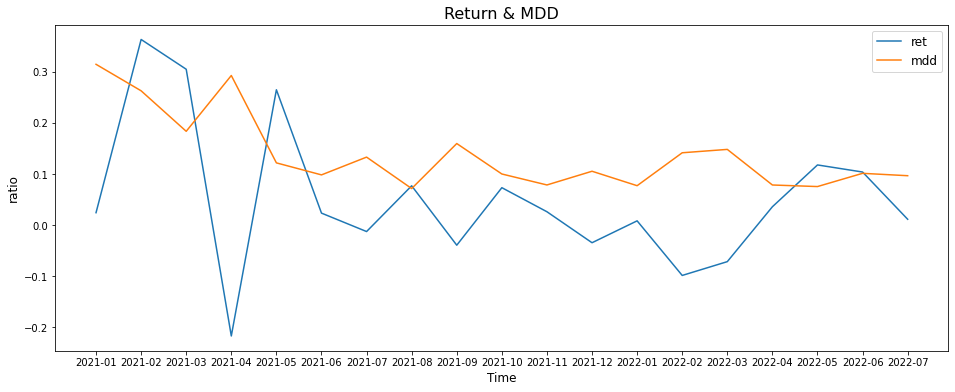

In [ ]:
fig, ax = plt.subplots(figsize = (16,6))
#perform_period['ret(month)'].plot(label='ret', ax = ax, grid=True)
plt.plot(perform_period['ret(month)'], label='ret')
plt.plot(perform_period['mdd(pct)'], label='mdd')
#plt.fill_between(perform_period.index, perform_period['mdd(value)'], facecolor='r', label='Drawdown', alpha=0.5)
plt.legend(fontsize=12)
plt.ylabel('ratio', fontsize=12)
plt.xlabel('Time', fontsize=12)
plt.title('Return & MDD',fontsize=16)

#### 進出、MDD圖

In [ ]:
# +-+-+-+-+-+-+ Plot InOut +-+-+-+-+-+-+
def InOut_Plot(Sample, InOutData):
    fig, ax = plt.subplots(figsize = (16,6))
    
    buy = InOutData[0]
    sell = InOutData[1]
    sellshort = InOutData[2]
    buytocover = InOutData[3]

    df = Sample[['close']][signal_interval:]
    
    df['close'].plot(label = 'Close Price', ax = ax, c = 'gray', grid=True, alpha=0.8)
    plt.scatter(df['close'].iloc[buy].index, df['close'].iloc[buy],c = 'orangered', label = 'Buy', marker='^', s=60)
    plt.scatter(df['close'].iloc[sell].index, df['close'].iloc[sell],c = 'orangered', label = 'Sell', marker='v', s=60)
    plt.scatter(df['close'].iloc[sellshort].index, df['close'].iloc[sellshort],c = 'limegreen', label = 'Sellshort', marker='v', s=60)
    plt.scatter(df['close'].iloc[buytocover].index, df['close'].iloc[buytocover],c = 'limegreen', label = 'Buytocover', marker='^', s=60)

    plt.legend()
    plt.ylabel('USD')
    plt.xlabel('Time')
    plt.title('Price Movement',fontsize  = 16)

# 做多檢視
def buy_sell(Sample, InOutData):
    fig, ax = plt.subplots(figsize = (16,6))
    
    buy = InOutData[0]
    sell = InOutData[1]
    sellshort = InOutData[2]
    buytocover = InOutData[3]

    df = Sample[['close']][signal_interval:]
    
    df['close'].plot(label = 'Close Price', ax = ax, c = 'gray', grid=True, alpha=0.8)
    plt.scatter(df['close'].iloc[buy].index, df['close'].iloc[buy],c = 'orangered', label = 'Buy', marker='^', s=60)
    plt.scatter(df['close'].iloc[sell].index, df['close'].iloc[sell],c = 'orangered', label = 'Sell', marker='v', s=60)

    plt.legend()
    plt.ylabel('USD')
    plt.xlabel('Time')
    plt.title('Price Movement',fontsize  = 16)

# 做空檢視
def sellshort_buytocover(Sample, InOutData):
    fig, ax = plt.subplots(figsize = (16,6))
    
    buy = InOutData[0]
    sell = InOutData[1]
    sellshort = InOutData[2]
    buytocover = InOutData[3]

    df = Sample[['close']][signal_interval:]
    
    df['close'].plot(label = 'Close Price', ax = ax, c = 'gray', grid=True, alpha=0.8)
    plt.scatter(df['close'].iloc[sellshort].index, df['close'].iloc[sellshort],c = 'limegreen', label = 'Sellshort', marker='v', s=60)
    plt.scatter(df['close'].iloc[buytocover].index, df['close'].iloc[buytocover],c = 'limegreen', label = 'Buytocover', marker='^', s=60)

    plt.legend()
    plt.ylabel('USD')
    plt.xlabel('Time')
    plt.title('Price Movement',fontsize  = 16)


# +-+-+-+-+-+-+ Plot MDD +-+-+-+-+-+-+ 
def MDD_Plot(equity):
    fig, ax = plt.subplots(figsize = (16,6))

    high_index = equity[equity['profitfee'].cummax() == equity['profitfee']].index
    equity['profitfee'].plot(label = 'Total Profit', ax = ax, c = 'r', grid=True)
    plt.fill_between(equity['drawdown'].index, equity['drawdown'], 0, facecolor  = 'r', label = 'Drawdown', alpha=0.5)
    plt.scatter(high_index, equity['profitfee'].loc[high_index],c = '#02ff0f', label = 'High')

    plt.legend()
    plt.ylabel('Accumulated Profit')
    plt.xlabel('Time')
    plt.title('Profit & Drawdown',fontsize  = 16)

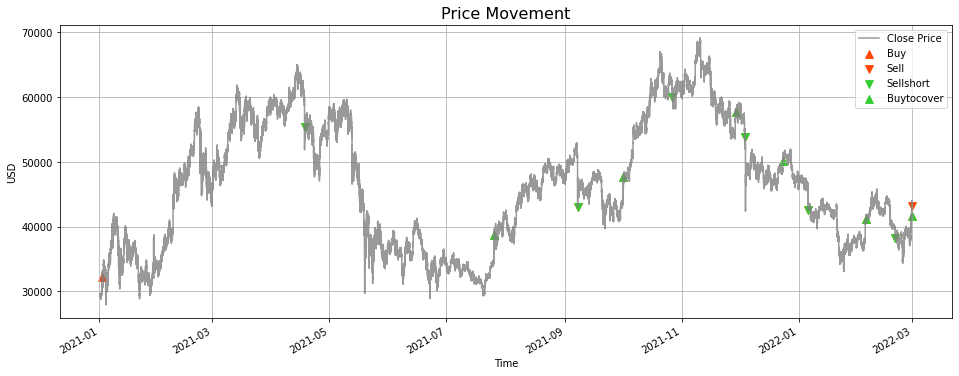

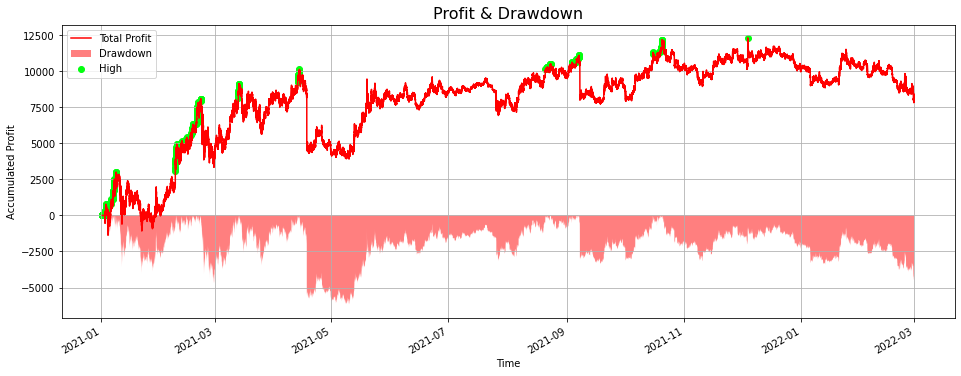

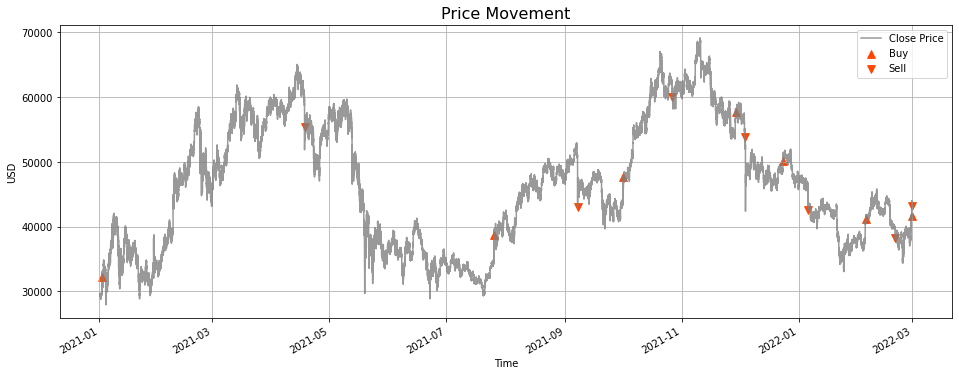

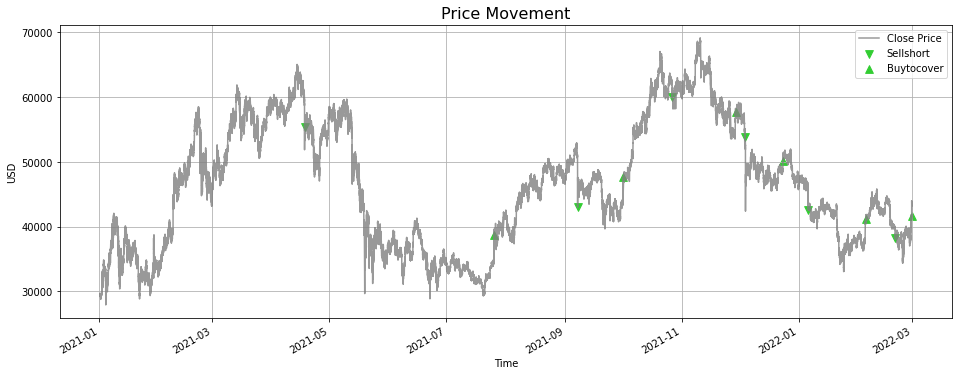

In [ ]:
InoutData_In  = (BackTest_In_Operate[2], BackTest_In_Operate[3], BackTest_In_Operate[4], BackTest_In_Operate[5])
InoutData_Out = (BackTest_Out_Operate[2], BackTest_Out_Operate[3], BackTest_Out_Operate[4], BackTest_Out_Operate[5])
InoutData_All = (BackTest_All_Operate[2], BackTest_All_Operate[3], BackTest_All_Operate[4], BackTest_All_Operate[5])

InOut_Plot(Sample_In, InoutData_In)
MDD_Plot(BackTest_In_Operate[0])
buy_sell(Sample_In, InoutData_In)
sellshort_buytocover(Sample_In, InoutData_In)

#### 權益曲線

In [ ]:
def EquityCurve_Plot(equity):
    equity['equity'].plot(grid=True, figsize=(16, 6))    # 未實現(每K算 非平倉才算)

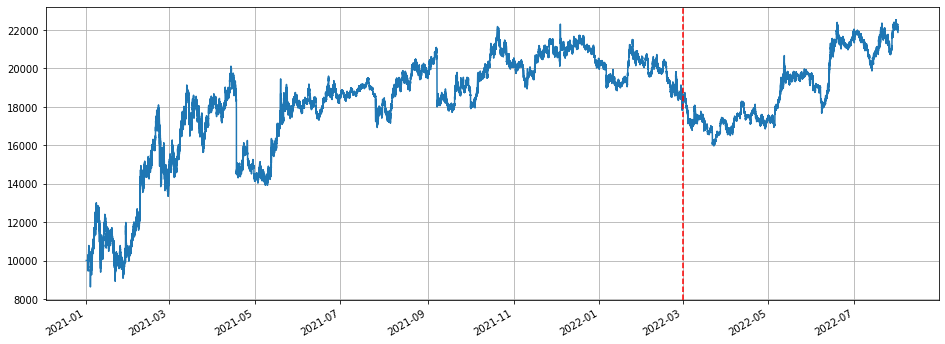

In [ ]:
# 切割線：https://vimsky.com/zh-tw/examples/usage/matplotlib-pyplot-axvline-in-python.html、https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.axvline.html
EquityCurve_Plot(equity_All)
plt.axvline(x = Sample_Out.index[0], linestyle ="--", c='r') 

## 圖像化分析

In [ ]:
Operate = pd.read_csv('drive/MyDrive/Colab Notebooks/Colab/TMBA/0821 分享/績效/OK)最佳化(Operate).csv', parse_dates=True)
Offset = pd.read_csv('drive/MyDrive/Colab Notebooks/Colab/TMBA/0821 分享/績效/OK)最佳化(Offset).csv', parse_dates=True)

In [ ]:
Operate = Operate.drop(columns='Unnamed: 0')
Offset = Offset.drop(columns='Unnamed: 0')

In [ ]:
Operate

,bre,set,ent,hour,ret_Cum,ret_Ann,vol_Ann,mdd,Sharpe_Ann,Sortino_Ann,Risk_to_Ret,winRate,TradeTimes,TradeFreq
0,2,1.0,2,24,0.397929,0.343432,1.029086,0.689126,0.333726,0.391978,0.577440,0.523810,21,0.049655
1,3,1.5,3,24,0.423401,0.365416,0.686350,0.407660,0.532405,0.659402,1.038612,0.461538,13,0.030739
2,4,2.0,4,24,-0.196093,-0.169238,0.737194,0.579625,-0.229570,-0.286607,-0.338310,0.375000,8,0.018916
3,2,1.0,2,12,-0.717305,-0.618339,0.857823,0.799103,-0.720823,-0.927214,-0.897637,0.333333,57,0.134619
4,3,1.5,3,12,-0.539945,-0.465449,1.093288,0.659291,-0.425733,-0.505834,-0.818977,0.407407,27,0.063767
5,4,2.0,4,12,0.818986,0.705991,0.690373,0.314419,1.022623,1.205330,2.604762,0.615385,13,0.030702
6,2,1.0,2,8,-0.371146,-0.319813,0.851681,0.764590,-0.375508,-0.485749,-0.485418,0.389610,77,0.181782
7,3,1.5,3,8,-0.840692,-0.724418,0.999912,0.885443,-0.724482,-0.874425,-0.949460,0.302326,43,0.101514
8,4,2.0,4,8,-0.523739,-0.451302,0.854328,0.730307,-0.528253,-0.677339,-0.717149,0.333333,21,0.049577
9,2,1.0,2,4,-0.859382,-0.740231,0.853613,0.888162,-0.867175,-1.114938,-0.967596,0.325714,175,0.412977


In [ ]:
BackTest_All_Operate[1].

Text(0.5, 0, 'trade number')

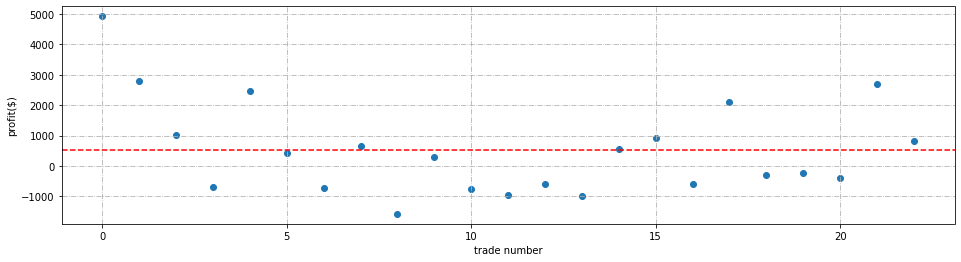

In [ ]:
mean = sum(BackTest_All_Operate[1]) / len(BackTest_All_Operate[1])
mean[0]

plt.figure(figsize=(16,4))
x = range(len(BackTest_All_Operate[1]));
y = BackTest_All_Operate[1]
s = plt.scatter(x,y)
plt.grid(linestyle='-.')
plt.axhline(y = mean[0], linestyle ="--", c='red') 

plt.ylabel('profit($)')
plt.xlabel('trade number')
